# Step-at-a-time optimization

One of the consequences of forcing our models to obey the markov property is that the dynamic behavior of the model can be represented entirely in the transition from one state of the system to the next. This means that if we have full measurement of the state of the system, we can separate the model's timeseries behavior into a series of independent timesteps. Now we can fit the model parameters to each timestep independently, without worrying about errors compounding thoughout the simulation.

We'll demonstrate this fitting of a model to data using PySD to manage our model, pandas to manage our data, and scipy to provide the optimization.


## About this technique
We can use this technique when we have full state information measurements in the dataset. It is particularly helpful for addressing oscillatory behavior.

In [2]:
%pylab inline
import pandas as pd
import pysd
import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


/Users/houghton/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Ingredients

### Model
In this demonstration we'll fit the [Lotka–Volterra Model](http://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equation) model: 
<img src="../../models/Predator_Prey/Predator_Prey.png" alt="Stock and Flow diagram of Lotka-Voltera model" style="width: 300px;"/>

In [3]:
model = pysd.read_vensim('../../models/Predator_Prey/Predator_Prey.mdl')

We will apply this model to a predator/prey system consisting of Didinium and Paramecium, that was described in:

    Veilleux (1976) "The analysis of a predatory interaction between Didinium and Paramecium", Masters thesis, University of Alberta.
    
There are four parameters in this model that it will be our task to set, with the goal of minimizing the sum of squared errors between the model's step-at-a-time prediction and the measured data.

### Data
The data we'll use was compiled from this work by [Christian Jost](http://robjhyndman.com/tsdldata/data/veilleux.dat).

,time(d),prey(#ind/ml),predator(#ind/ml)
0,0.0,15.65,5.76
1,0.5,53.57,9.05


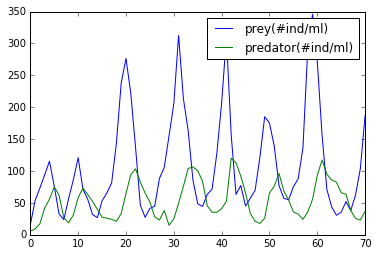

In [4]:
data = pd.read_csv('../../data/Predator_Prey/Veilleux_CC_0.5_Pretator_Prey.txt', sep='\s+', header=4)
data[['prey(#ind/ml)','predator(#ind/ml)']].plot();
data.head(2)

## The Recipe

### Step 1: Shape the dataset such that each row contains the start and end of a 'step'
As we are analyzing the model a step at a time, it makes sense to restructure our dataframe so that each row contains both the starting and final state of each step. We can do this by merging the dataset with itself, offset by one row. We'll add suffixes to the columns to differentiate between the start and end of each step.

While this method increases the burden of data that we have to carry, it allows us to use pandas's `apply` functionality to increase computational speed over a `for` loop.

In [4]:
data_steps = pd.merge(data.iloc[:-1], data.iloc[1:].reset_index(drop=<<...>>), 
                      left_index=True, right_index=True, <<...>>=('_s','_f'))
data_steps.head()

,time(d)_s,prey(#ind/ml)_s,predator(#ind/ml)_s,time(d)_f,prey(#ind/ml)_f,predator(#ind/ml)_f
0,0.0,15.65,5.76,0.5,53.57,9.05
1,0.5,53.57,9.05,1.0,73.34,17.26
2,1.0,73.34,17.26,1.5,93.93,41.97
3,1.5,93.93,41.97,2.0,115.40,55.97
4,2.0,115.40,55.97,2.5,76.57,74.91


### Step 2: Define a single-step error function

We define a function that takes a single step and calculates the sum squared error between the model's prediction of the final datapoint and the actual measured value. The most complicated parts of this function are making sure that the data columns line up properly with the model components.

Note that in this function we don't set the parameters of the model - we can do that just once in the next function.

In [5]:
def one_step_error(row):
    result = model.run(return_timestamps=[row['time(d)_f']],
                       initial_condition=(row['time(d)_s'], 
                                          {'predator_population':row['predator(#ind/ml)_s'],
                                           'prey_population':row['prey(#ind/ml)_s']}))
    <<...>> = ((result.loc[row['time(d)_f']]['predator_population'] - row['predator(#ind/ml)_f'])**2 + 
           (result.loc[row['time(d)_f']]['prey_population'] - row['prey(#ind/ml)_f'])**2 )
    return sse  

### Step 3: Define an error function for the full dataset
Now we define a function that sets the parameters of the model based upon the optimizer's suggestion, and computes the sum squared error for all steps.

In [6]:
def error(parameter_list):
    parameter_names = ['predation_rate', 'prey_fertility', 'predator_mortality', 'predator_food_driven_fertility']
    model.set_components(params=dict(zip(parameter_names, parameter_list)))
    
    errors = data_steps.apply(one_step_error, axis=1)
    return errors.<<...>>

error([.005, 1, 1, .002])

545152.61053738836

Now we're ready to use scipy's built-in optimizer.

In [7]:
res = scipy.optimize.minimize(<<...>>, x0=[.005, 1, 1, .002], method='L-BFGS-B', 
                              bounds=[(0,10), (0,None), (0,10), (0,None)])

### Result
We can plot the behavior of the system with our fit parameters over time:

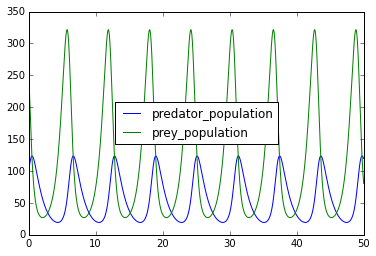

In [8]:
predation_rate, prey_fertility, predator_mortality, predator_food_driven_fertility = res.x
values = model.run(params={'predation_rate':predation_rate,
                           'prey_fertility':prey_fertility, 
                           'predator_mortality':predator_mortality, 
                           'predator_food_driven_fertility':predator_food_driven_fertility})

values.plot()